In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [2]:
deep_reload(src)

filepath = 'Data/Places/tl_2023_06_place.shp'
node_attributes = {
    'name': 'lambda n: n["NAME"]',
    'class': 'lambda n: n["CLASSFP"]',
    'geoid': 'lambda n: n["GEOID"]',
    'x': 'lambda n: n["geometry"].centroid.x',
    'y': 'lambda n: n["geometry"].centroid.y',
}

graph_place = src.graph.graph_from_shapefile(
    filepath, node_attributes, contains_links = False)

In [3]:
deep_reload(src)

filepath = 'Data/Places/SUB-IP-EST2022-POP-06.xlsx'

kw = {
    'skiprows': 3,
    'skipfooter': 5,
    'usecols': ['Unnamed: 0', 'Unnamed: 1'],
}

df_place = src.graph.dataframe_from_xlsx(filepath, **kw)

df_place = df_place.rename(
    columns = {
        'Unnamed: 0': 'place',
        'Unnamed: 1': 'population'
    }
)

df_place['place'] = df_place['place'].apply(lambda s: s.replace(' city, California', ''))
df_place['place'] = df_place['place'].apply(lambda s: s.replace(' town, California', ''))

dict_place = {row[1]['place']: row[1].to_dict() for row in df_place.iterrows()}

for source, node in graph_place._node.items():

    node['population'] = dict_place.get(node['name'], {'population': 0})['population']

In [4]:
deep_reload(src)

filepath = 'Data/NGOD/2021_Passenger_OD_Annual_Data.csv'
kw = {}

df_ngod = src.graph.dataframe_from_csv(filepath, **kw)

df_ngod_california = df_ngod[(
    (df_ngod['origin_state'] == 'CA') &
    (df_ngod['destination_state'] == 'CA')
)]

In [5]:
gdf_zones = gpd.read_file('Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [6]:
source_zone = df_ngod_california['origin_zone_id'].to_numpy()
target_zone = df_ngod_california['destination_zone_id'].to_numpy()
vehicle_travel = df_ngod_california['mode_vehicle'].to_numpy()

dict_ngod_california = {}

for s in source_zone:

    dict_ngod_california[s] = {}
    source_target_zones = target_zone[source_zone == s]
    source_vehicle_travel = vehicle_travel[source_zone == s]
    
    for idx, t in enumerate(source_target_zones):

        dict_ngod_california[s][t] = source_vehicle_travel[idx] 

In [8]:
# Assigning places to zones
deep_reload(src)

for source, node in graph_place._node.items():

    node['zone'] = 'other'

for idx, row in gdf_zones_california.iterrows():

    polygon = np.array(row['geometry'].exterior.coords)

    for source, node in graph_place._node.items():

        point = [node['x'], node['y']]

        in_zone = src.in_polygon.ray_tracing(polygon, point)

        if in_zone:

            node['zone'] = row['V2ZONEID']

In [9]:
# Removing nodes not in zones

remove = []

for source, node in graph_place._node.items():

    if node['zone'] == 'other':

        remove.append(source)

graph_place.remove_nodes_from(remove)

In [10]:
# Zone populations

zone_population = {}

for source, node in graph_place._node.items():

    zone = node['zone']

    if zone in zone_population.keys():

        zone_population[zone] += node['population']

    else:

        zone_population[zone] = node['population']

In [11]:
# Adding edges

edges = []

for source, source_node in graph_place._node.items():

    for target, target_node in graph_place._node.items():

        source_zone = str(source_node['zone'])
        target_zone = str(target_node['zone'])

        total_vehicle_travel = dict_ngod_california[source_zone][target_zone]

        source_portion = source_node['population'] / zone_population[source_zone]
        target_portion = target_node['population'] / zone_population[target_zone]

        volume = total_vehicle_travel * source_portion * target_portion

        edges.append((source, target, {'volume': volume}))

In [12]:
graph_place.add_edges_from(edges)

In [13]:
filename = 'Outputs/place_adj.json'

src.graph.graph_to_json(graph_place, filename)

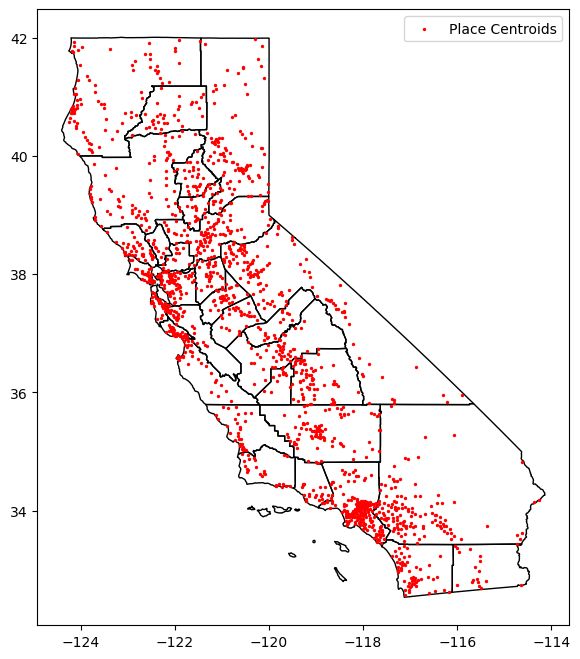

In [23]:
fig, ax = plt.subplots(figsize = (8, 8))

x = np.array([n['x'] for n in graph_place._node.values()])
y = np.array([n['y'] for n in graph_place._node.values()])

gdf_zones[gdf_zones['in_california']].plot(
    ax = ax, ec = 'k', fc = 'none', label = 'O/D Zones')

_ = ax.scatter(x, y, color = 'r', s = 2, label = 'Place Centroids')

_ = ax.legend()